<a href="https://colab.research.google.com/github/JonNData/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/Jon_Nguyen_LS_DS_221_Trees_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [5]:
sample_submission.shape

(14358, 2)

In [3]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [4]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
# Do train/validate/test split with the Tanzania Waterpumps data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = 0.85, test_size = 0.15, 
                              stratify = train['status_group'], random_state =11)

In [8]:
# Begin with baseline
train['status_group'].value_counts(normalize=True)

# Would guess always functional and be right 0.543078 in our train set.

functional                 0.543078
non functional             0.384235
functional needs repair    0.072688
Name: status_group, dtype: float64

In [0]:
import numpy as np

def coordinate_fix(df):
  '''
  Codify latitude 0s and replace them with NaNs
  '''

  df = df.copy()
  df['latitude'] = df['latitude'].replace(-2e-08, 0)

  cols_w_zero = ['longitude', 'latitude']
  for col in cols_w_zero:
    df[col] = df[col].replace(0, np.nan)

  df = df.drop(columns = 'quantity_group')

  return df

In [0]:
train = coordinate_fix(train)
val = coordinate_fix(val)
test = coordinate_fix(test)

In [13]:
#  Select features. Use a scikit-learn pipeline to encode categoricals,
#  impute missing values, and fit a decision tree classifier.

target = 'status_group'

train_features = train.drop(columns = [target, 'id'])
num_features = train_features.select_dtypes(include= 'number').columns.tolist()

cardinal = train_features.select_dtypes(exclude = 'number').nunique()

categorical_features = cardinal[cardinal <= 50].index.tolist()

features = num_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [15]:
train[features].select_dtypes(exclude='number').nunique()

basin                     9
region                   21
public_meeting            2
recorded_by               1
scheme_management        12
permit                    2
extraction_type          18
extraction_type_group    13
extraction_type_class     7
management               12
management_group          5
payment                   7
payment_type              7
water_quality             8
quality_group             6
quantity                  5
source                   10
source_type               7
source_class              3
waterpoint_type           7
waterpoint_type_group     6
dtype: int64

In [0]:
# Arrange data into X features matrix and y target vector 

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [19]:
train['extraction_type'].value_counts()

gravity                      22811
nira/tanira                   6913
other                         5471
submersible                   4046
swn 80                        3079
mono                          2459
india mark ii                 2037
afridev                       1509
ksb                           1186
other - rope pump              377
other - swn 81                 194
windmill                        98
india mark iii                  84
cemo                            78
other - play pump               76
walimi                          40
climax                          30
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [0]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    SimpleImputer(missing_values=np.nan,strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf= 20, random_state = 11)
)


In [29]:
# Get val score
pipeline.fit(X_train, y_train)

print('Validation accuracy:', pipeline.score(X_val,y_val))


Validation accuracy: 0.76341189674523


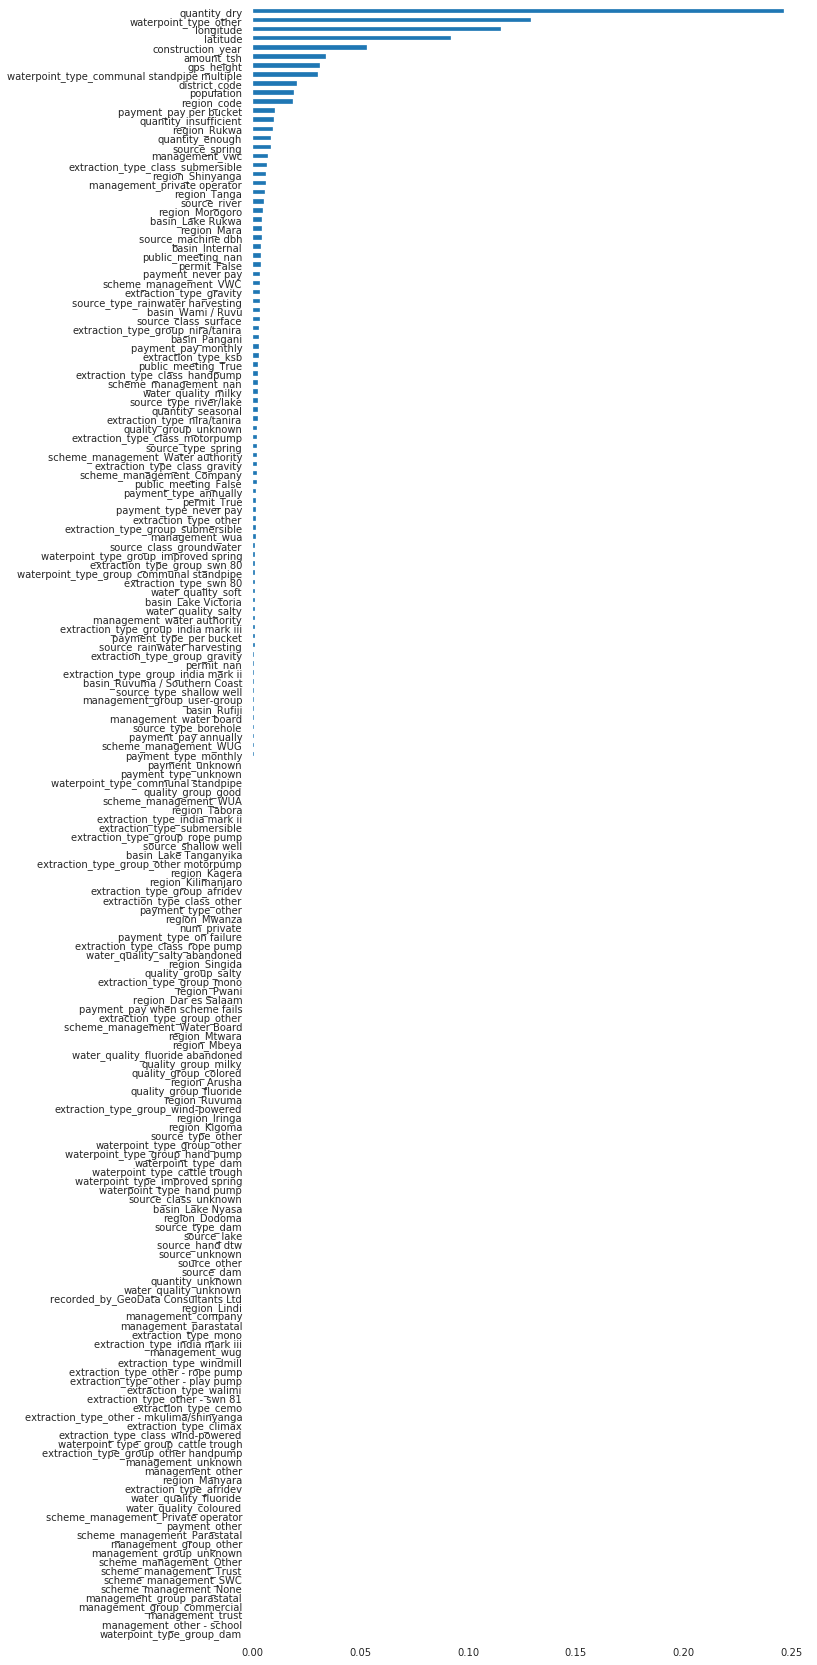

In [36]:
# plot feature importances
import seaborn as sns
import matplotlib.pyplot as plt


raw_importances = pipeline.named_steps.decisiontreeclassifier.feature_importances_

encoder = pipeline.named_steps['onehotencoder']
encoded_col = encoder.transform(X_val).columns

importances = pd.Series(raw_importances, encoded_col)

plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()

In [43]:
# More attempts

# troll attempt
from sklearn.linear_model import LogisticRegression
target = 'status_group'

features = 'management_group'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    LogisticRegression()
)
pipeline.fit(X_train, y_train)

print('Validation accuracy:', pipeline.score(X_val,y_val))
# I wanted a lower score than that so not worth submitting

Validation accuracy: 0.5439955106621773


In [44]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [53]:
# Stretch: Try other imputers

from sklearn.impute import KNNImputer
target = 'status_group'

features = num_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    KNNImputer(n_neighbors=3),
    DecisionTreeClassifier(min_samples_leaf= 20, random_state = 11)
)
pipeline.fit(X_train, y_train)

print('Validation accuracy:', pipeline.score(X_val,y_val))

Validation accuracy: 0.7661054994388328


In [54]:
# Just make the model on the whole choo-choo
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names= True),
    KNNImputer(n_neighbors=3),
    DecisionTreeClassifier(min_samples_leaf= 20, random_state = 11)
)
pipeline.fit(X_train, y_train)

print('Validation accuracy:', pipeline.score(X_val,y_val))

Validation accuracy: 0.8094276094276094


In [0]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = pipeline.predict(X_test)


# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('jon_nguyen_1st_attempt.csv', index=False)

In [56]:
df = pd.read_csv('jon_nguyen_1st_attempt.csv')
df

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional
